In [ ]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device:', device)

train_data = datasets.MNIST(root='./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data',
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

In [2]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size
                                           )
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size
                                          )

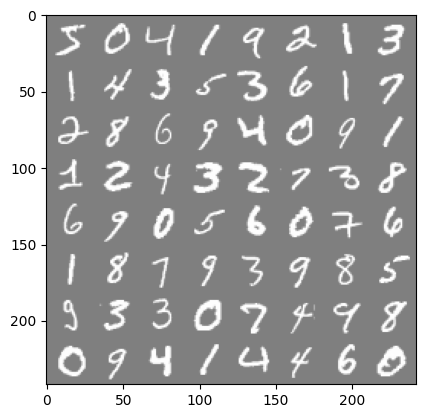

60000
10000

938
157

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(len(train_data))
print(len(test_data))
print()

print(len(train_loader))
print(len(test_loader))
print()

for img, label in train_loader:
  print(img.size())
  print(label.size())
  break

# 1) Autoencoder

In [ ]:
# # encoder:
# 1) input
# 2) conv layers (conv+relu)
# 3) flatten last conv layer
# 4) dense layer (size:2 = 2D latent space)

In [ ]:
# # decoder
# 1) input (size: dim of latent space)
# 2) dense layer
# 3) reshaping: vector --> tensor
# 4) conv transplose layers
# 5) activation

In [ ]:
class AutoEncoderModel(nn.Module):
    def __init__(self):
        super().__init__()

        ## encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)


    def forward(self, x):
        ## encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        ## decoder
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        return x

model = AutoEncoderModel().to(device)
print(model)


AutoEncoderModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [ ]:
# returns encoder embeddings

class AutoEncoderModel_ENC(nn.Module):
    def __init__(self):
        super().__init__()

        ## encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)


    def forward(self, x):
        ## encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        encoded = x

        ## decoder
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        return x, encoded


This part is simply taken from Sebastian Rashcka's AutoEncoder course.
Related Repo: https://github.com/rasbt/stat453-deep-learning-ss21/tree/main/L16

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoderModel_2(nn.Module):
    def __init__(self):
        super().__init__()

        # ENCODER
        self.encoder = nn.Sequential( #784
                # 28, 28, 1   transforms to:
                # 28, 28, 32
                nn.Conv2d(1, 32, stride=1, kernel_size=3, padding=1),
                nn.ReLU(True),                                        # nn.LeakyReLU(0.01) another opt.

                # 14, 14, 64
                nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=1),
                nn.ReLU(True),

                # 7, 7, 64
                nn.Conv2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.ReLU(True),

                # 7, 7, 64
                nn.Conv2d(64, 64, stride=1, kernel_size=3, padding=1),

                # 7*7*64 = 3136 ==> 2
                nn.Flatten(),
                nn.Linear(3136, 2)
        )

        # DECODER
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),

                # 7, 7, 64
                nn.ConvTranspose2d(64, 64, stride=1, kernel_size=3, padding=1),
                nn.ReLU(True),

                # 7, 7, 64
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.ReLU(True),

                # 14, 14, 64
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=0),
                nn.ReLU(True),

                # 28, 28, 32
                nn.ConvTranspose2d(32, 1, stride=1, kernel_size=3, padding=0),
                Trim(),
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AutoEncoderModel_2().to(device)
print(model)


In [ ]:
summary(model, (1, 28, 28))

In [ ]:
# # loss selection
# binary CE, penalties heavier for too bad predictions
# --> pixel predictions to the middle of the range
# --> less vibrant images

# RMSE


### Training

In [ ]:
EPOCH_NUM = 5
LR = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []

for epoch in range(EPOCH_NUM):
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()           # optionally, *images.size(0)

    train_loss = train_loss/len(train_loader)
    train_losses.append(loss.detach().cpu().numpy())
    print(f'Epoch {epoch+1}-Training Loss: {train_loss}')

Epoch 1-Training Loss: 0.9570488718986512
Epoch 2-Training Loss: 0.4453891120592753
Epoch 3-Training Loss: 0.39976047967274986
Epoch 4-Training Loss: 0.3758093184153239
Epoch 5-Training Loss: 0.3620507950226466


### Evaluation

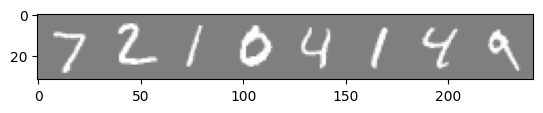

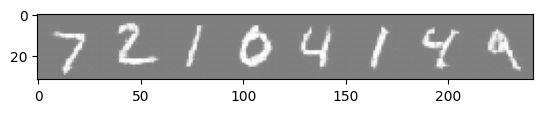

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

output = model(images)
output = output.view(batch_size, 1, 28, 28)


imshow(torchvision.utils.make_grid(images.cpu()[:8]))
imshow(torchvision.utils.make_grid(output.cpu()[:8]))


In [ ]:
# Create subset for t-SNE plots

from torchvision import datasets, transforms
from torch.utils.data import Subset

print(len(train_data))
num_samples = 30000

subset_indices = torch.randperm(len(train_data))[:num_samples]
subset_data = Subset(train_data, subset_indices)

print(len(subset_data))

In [ ]:
from sklearn.manifold import TSNE
from tqdm import tqdm

model = AutoEncoderModel_ENC().to(device)

encoded_images = []
labels = []
with torch.no_grad():
    for images, labels_batch in tqdm(train_data):
        images = images.unsqueeze(0).to(device)
        reconstructed, encoded = model(images)
        encoded_images.append(encoded.squeeze().cpu().numpy())
        labels.append(labels_batch)


encoded_images = torch.tensor(encoded_images)
encoded_images_flattened = encoded_images.reshape(encoded_images.shape[0], -1)
labels = torch.tensor(labels)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(encoded_images_flattened)


100%|██████████| 60000/60000 [00:45<00:00, 1327.48it/s]


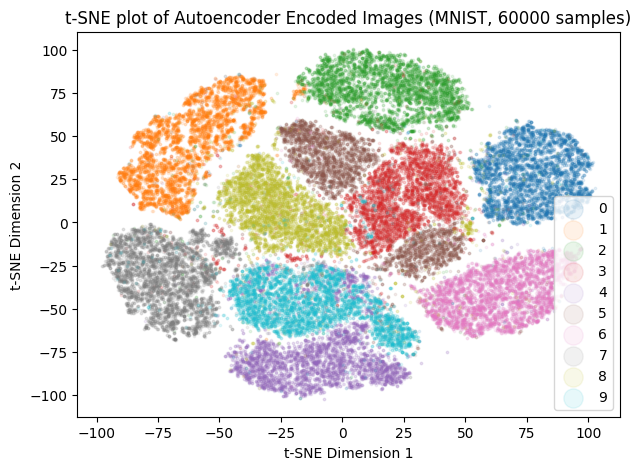

In [ ]:
plt.figure(figsize=(7, 5))
for i in range(10):
    plt.scatter(X_tsne[labels == i, 0],
                X_tsne[labels == i, 1],
                label=str(i),
                alpha=0.1,
                s=3,
                )

plt.legend(markerscale=8)
plt.title('t-SNE plot of Autoencoder Encoded Images (MNIST, 60000 samples)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# 2) VAE

In [ ]:
# ### VAE's
# # assumption: no corr. btw any of the dim's in latent space
# # ==> cov matrix is diagonal.
# # ==> encoder maps each input ==> mean vector and variance vector
# # ==> do not require cov btw dimensions

# # encoding: input image ==> mu AND log vector
# # ==> multivariate normal distribution

# 1) connect flattened layer to mu and log var
# 2) get mu and log var for image input
# 3) sample a point z in latent space from dist (mu and log var)

# !!! IN EACH FORWARD PASS, sampling from distribution occurs

In [ ]:
# # KL div for VAEs
# KL div: measure how much one prob dist differs from another
# in a VAE, how diff our normal dist <--> std normal dist

# KL div penalizes the network for encoding observations where
# mu and log avr differs from params of a std normal dist

# sum KL div's for all latent dimensions and get mean
# summary: force all encoded distributions toward the std norm dist

# Loss = MSE + KL div(mean of dimensions)

This part is simply taken from Sebastian Rashcka's AutoEncoder course: https://github.com/rasbt/stat453-deep-learning-ss21/tree/main/L17

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VariationalAutoEncoderModel_2(nn.Module):
    def __init__(self):
        super().__init__()

        # ENCODER
        self.encoder = nn.Sequential( #784
                # 28, 28, 1   transforms to:
                # 28, 28, 32
                nn.Conv2d(1, 32, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),

                # 14, 14, 64
                nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),

                # 7, 7, 64
                nn.Conv2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),

                # 7, 7, 64
                nn.Conv2d(64, 64, stride=1, kernel_size=3, padding=1),

                # 7*7*64 = 3136 ==> 2
                nn.Flatten(),
                # # # nn.Linear(3136, 2)        # do not use in VAE
        )

        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)

        # DECODER
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),

                # 7, 7, 64
                nn.ConvTranspose2d(64, 64, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),

                # 7, 7, 64
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),

                # 14, 14, 64
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=0),
                nn.LeakyReLU(0.01),

                # 28, 28, 32
                nn.ConvTranspose2d(32, 1, stride=1, kernel_size=3, padding=0),
                Trim(),
                nn.Sigmoid()
                )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        return mu + eps * std    # = z

    def forward(self, x):
        x = self.encoder(x)

        # sampling w/ mean and dev for each forward pass
        mu, logvar = self.z_mean(x), self.z_log_var(x)
        z = self.reparameterize(mu, logvar)

        decoded = self.decoder(z)
        return z, mu, logvar, decoded



model = VariationalAutoEncoderModel_2().to(device)
print(model)
# print(summary(model, (1, 28, 28)))


In [5]:
def loss_KL_div(mu, logvar):
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=-1)
    return loss

def rec_loss(reconstructed_imgs, images):
    loss_mse = F.mse_loss
    return loss_mse(reconstructed_imgs, images, reduction='none')


In [ ]:
EPOCH_NUM = 30
LR = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = F.mse_loss

train_losses = []
kl_div_losses_p_batch = []
recon_losses_p_batch = []
total_losses_p_batch = []

for epoch in range(EPOCH_NUM):
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        optimizer.zero_grad()

        z, mu, logvar, decoded_outputs = model(images)

        # loss = rec loss + kl div loss
        kl_div = loss_KL_div(mu, logvar)
        kl_div = kl_div.mean()

        recon_loss = rec_loss(decoded_outputs, images)
        recon_loss = recon_loss.view(batch_size, -1).sum(axis=1)
        recon_loss = recon_loss.mean()

        loss = recon_loss + kl_div

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        kl_div_losses_p_batch.append(kl_div.item())
        recon_losses_p_batch.append(recon_loss.item())
        total_losses_p_batch.append(loss.item())


    train_loss = train_loss/len(train_loader)
    train_losses.append(loss.detach().cpu().numpy())
    print(f'Epoch {epoch+1} | Training Loss: {train_loss}')
    # print(f"kl div loss:{kl_div}  |  rec loss:{recon_loss}")

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label='Train Loss')
plt.title('Training Losses of VAE')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plotting the train losses
plt.figure(figsize=(6, 4))
plt.plot(kl_div_losses_p_batch, label='KL Div Loss per Batch')
plt.plot(recon_losses_p_batch, label='Reconstruction Loss per Batch')
plt.plot(total_losses_p_batch, label='Total Loss per Batch')
plt.title('Training Losses (per batch) of VAE')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

z, mu, logvar, decoded_outputs = model(images)
output = decoded_outputs.view(batch_size, 1, 28, 28)


imshow(torchvision.utils.make_grid(images.cpu()[:8]))
imshow(torchvision.utils.make_grid(output.cpu()[:8]))


In [ ]:
from sklearn.manifold import TSNE
from tqdm import tqdm

model = VariationalAutoEncoderModel_2().to(device)

encoded_images = []
labels = []
with torch.no_grad():
    for images, labels_batch in tqdm(train_data):
        images = images.unsqueeze(0).to(device)
        z, mu, logvar, decoded_outputs = model(images)
        encoded_images.append(z.squeeze().cpu().numpy())
        labels.append(labels_batch)


encoded_images = torch.tensor(encoded_images)
encoded_images_flattened = encoded_images.reshape(encoded_images.shape[0], -1)
labels = torch.tensor(labels)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(encoded_images_flattened)



In [ ]:
plt.figure(figsize=(7, 5))
for i in range(10):
    plt.scatter(X_tsne[labels == i, 0],
                X_tsne[labels == i, 1],
                label=str(i),
                alpha=0.2,
                s=3,
                )

plt.legend(markerscale=8)
plt.title('t-SNE plot of VAE Encoded Images (MNIST, 60000 samples)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()